In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import torchvision
from torchvision import transforms
import os

In [19]:
base_dir = r'./icebergAndship'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')   
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=train_transform
    )
test_ds =  torchvision.datasets.ImageFolder(
        test_dir,
        transform=test_transform
    )
BTACH_SIZE = 16
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=BTACH_SIZE,
                            shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=BTACH_SIZE,
)

In [20]:
model = torchvision.models.densenet161(pretrained=True)

D:\anaconda\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
D:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [22]:
for param in model.parameters():
    param.requires_grad = False

In [23]:
in_f=model.classifier.in_features
model.classifier=nn.Linear(in_f,2)

In [24]:
if torch.cuda.is_available():
    model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [25]:
epochs = 50
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.037 accuracy: 0.671 test_loss：  0.038 test_accuracy: 0.664
epoch:  1 loss：  0.032 accuracy: 0.737 test_loss：  0.029 test_accuracy: 0.779
epoch:  2 loss：  0.03 accuracy: 0.779 test_loss：  0.029 test_accuracy: 0.751
epoch:  3 loss：  0.03 accuracy: 0.759 test_loss：  0.029 test_accuracy: 0.751
epoch:  4 loss：  0.032 accuracy: 0.74 test_loss：  0.028 test_accuracy: 0.794
epoch:  5 loss：  0.028 accuracy: 0.769 test_loss：  0.027 test_accuracy: 0.757
epoch:  6 loss：  0.028 accuracy: 0.783 test_loss：  0.031 test_accuracy: 0.791
epoch:  7 loss：  0.029 accuracy: 0.767 test_loss：  0.027 test_accuracy: 0.769
epoch:  8 loss：  0.027 accuracy: 0.783 test_loss：  0.026 test_accuracy: 0.763
epoch:  9 loss：  0.026 accuracy: 0.808 test_loss：  0.027 test_accuracy: 0.782
epoch:  10 loss：  0.026 accuracy: 0.8 test_loss：  0.026 test_accuracy: 0.769
epoch:  11 loss：  0.026 accuracy: 0.8 test_loss：  0.027 test_accuracy: 0.769
epoch:  12 loss：  0.026 accuracy: 0.787 test_loss：  0.027 test_accura

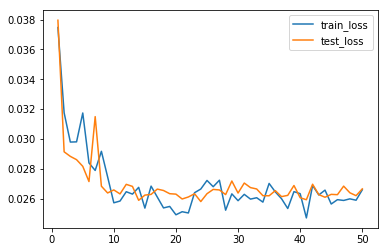

In [26]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

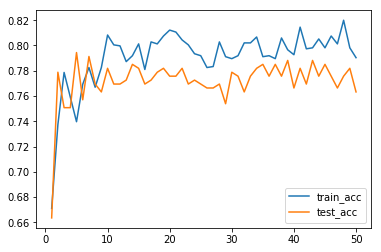

In [27]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()